## notes 
include graphs that show multi words 
measure multiwords by seeing if the frequency of combination of multiple characters is greater than the characters individually or combined 

In [1]:
%pip install pypinyin

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\tbhro\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
from __future__ import annotations
from collections import Counter, defaultdict
from typing import Dict, Iterable
from pypinyin import pinyin, Style

import pandas as pd

In [3]:
dataframe = pd.read_csv("C:\\Users\\tbhro\\PycharmProjects\\nlp-bpc\\zho_data\\first_part.csv", encoding="utf-8")
zho_text = dataframe["text"].tolist()
# print(zho_text)
# Remove \r\n from each string in the zho_text list
zho_text_cleaned = [text.replace("\r\n", "") for text in zho_text]
# print(zho_text_cleaned)


In [4]:
# train
def is_chinese_char(ch: str) -> bool:
    """Rudimentary check if ch is a CJK Unified Ideograph."""
    return "\u4e00" <= ch <= "\u9fff"


def char_to_initial(ch: str) -> str | None:
    """
    Convert a single Chinese character to the first letter of its pinyin.
    Example: '我' -> 'w', '要' -> 'y'
    Returns None if pinyin can't be obtained.
    """
    if not is_chinese_char(ch):
        return None

    py_list = pinyin(ch, style=Style.NORMAL, strict=False)
    if not py_list or not py_list[0]:
        return None

    syllable = py_list[0][0]  # e.g. 'wo', 'yao', 'shui'
    return syllable[0].lower()  # first letter: 'w', 'y', 's', 'j', ...


def build_initial_to_char_counts(texts: Iterable[str]) -> Dict[str, Counter]:
    """
    Build a frequency table:
    initial_letter -> Counter({character: count, ...})
    from an iterable of Chinese texts.
    """
    mapping: Dict[str, Counter] = defaultdict(Counter)

    for text in texts:
        for ch in text:
            if not is_chinese_char(ch):
                continue
            initial = char_to_initial(ch)
            if initial is None:
                continue
            mapping[initial][ch] += 1

    return mapping

In [5]:
# decoding  
def build_initial_to_best_char(initial_to_counts: Dict[str, Counter]) -> Dict[str, str]:
    """
    For each initial letter, pick the single most frequent character.
    Example: {'w': Counter({'我': 1234, '问': 200, ...})}
    -> {'w': '我'}
    """
    best: Dict[str, str] = {}
    for initial, counter in initial_to_counts.items():
        most_common_char, _ = counter.most_common(1)[0]
        best[initial] = most_common_char
    return best

def decode_initial_sequence(
    initials: str,
    initial_to_best_char: Dict[str, str],
    unknown_char: str = "□",
) -> str:
    """
    Convert an initial-letter sequence (e.g. 'wysj')
    to a Chinese string using a simple per-initial mapping.

    unknown_char: used when an initial is not in the learned mapping.
    """
    result_chars = []
    for letter in initials.lower().strip():
        result_chars.append(initial_to_best_char.get(letter, unknown_char))
    return "".join(result_chars)


In [ ]:
# trial 
if __name__ == "__main__":
    # ===== 1. Example training data =====
    training_texts = zho_text_cleaned

    # ===== 2. Train frequency statistics =====
    initial_to_counts = build_initial_to_char_counts(training_texts)
    initial_to_best_char = build_initial_to_best_char(initial_to_counts)

    # print("Most frequent char per initial:")
    # for init, ch in sorted(initial_to_best_char.items()):
    #     print(f"{init} -> {ch}")

    # # ===== 3. Decode some initial sequences =====
    # examples = ["wysj", "wxsj", "yxlx"]
    # for seq in examples:
    #     hanzi = decode_initial_sequence(seq, initial_to_best_char)
    #     print(f"{seq} -> {hanzi}")

# 16 minutes


## Heatmap

In [7]:
from collections import Counter, defaultdict
from typing import Dict, Iterable, List, Tuple
import os
import string
import numpy as np
import matplotlib.pyplot as plt
from pypinyin import pinyin, Style

In [8]:
# ---------- 2. Build matrix for selected characters & initials ----------

def build_matrix(
    initial_to_counts: Dict[str, Counter],
    initials: List[str] | None = None,
    extra_chars: List[str] | None = None,
    top_k_per_initial: int = 5,
) -> Tuple[List[str], List[str], np.ndarray]:
    """
    Build a matrix of shape (num_chars, num_initials), where
    entry [i, j] = frequency of character_i with initial_j in the corpus.

    - initials: which initials to keep (e.g. ["w", "y", "s", "j"]).
      If None, uses all initials found.
    - extra_chars: characters that must always be included as rows,
      even if they are not top-k.
    - top_k_per_initial: additionally include the top-k characters
      (by frequency) for each initial.
    """
    if initials is None:
        initials = sorted(initial_to_counts.keys())
    else:
        initials = sorted(set(initials) & set(initial_to_counts.keys()))

    # collect characters to appear as rows
    char_set = set(extra_chars or [])
    for init in initials:
        for ch, _ in initial_to_counts[init].most_common(top_k_per_initial):
            char_set.add(ch)

    # chars = sorted(char_set)  # row order
    # Sort characters by frequency (descending order)
    chars = sorted(
        char_set,
        key=lambda ch: sum(initial_to_counts[init][ch] for init in initials if ch in initial_to_counts[init]),
        reverse=True,
    )

    # build matrix
    mat = np.zeros((len(chars), len(initials)), dtype=int)
    for i, ch in enumerate(chars):
        for j, init in enumerate(initials):
            mat[i, j] = initial_to_counts[init][ch]

    return initials, chars, mat

In [9]:
# ---------- 3. Pretty-print as table ----------

def print_matrix(initials: List[str], chars: List[str], mat: np.ndarray) -> None:
    """
    Print matrix in a text format like:

           w   y   s   j
    我    34   0   0   0
    要     0  29   0   0
    """
    # Header
    header = "    " + " ".join(f"{init:>4}" for init in initials)
    print(header)

    # Rows
    for i, ch in enumerate(chars):
        row_counts = " ".join(f"{mat[i, j]:>4}" for j in range(len(initials)))
        print(f"{ch:<2}  {row_counts}")


In [10]:
def show_heatmap(initials: List[str], chars: List[str], mat: np.ndarray) -> None:
    """
    Simple heatmap visualization.
    """
    plt.rcParams["font.sans-serif"] = ["SimHei", "Microsoft YaHei"] # for Chinese characters
    plt.figure(figsize=(8, max(4, len(chars) * 0.4)))
    plt.imshow(mat, aspect="auto")
    plt.colorbar(label="Frequency")
    plt.xticks(range(len(initials)), initials)
    plt.yticks(range(len(chars)), chars)
    plt.xlabel("Pinyin initial")
    plt.ylabel("Chinese character")
    plt.title("Character frequency conditioned on pinyin initial")
    plt.tight_layout()



       a
啊   927225
哎   112099
爱   111393
安   101967
案   46887
阿   39966
按   21328
暗   11893


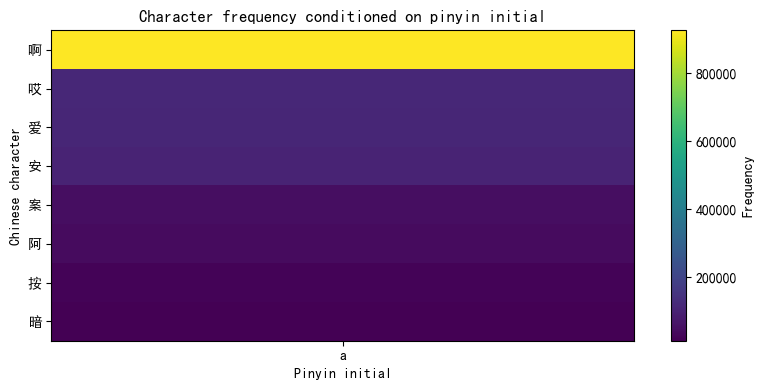

       b
不   2104071
吧   391425
别   282208
把   274796
本   143937
比   126343
被   120719
边   116769
爸   113968
百   105102
白   102866
办   95698
帮   90384
部   88094
八   78498
报   78093
保   73911
变   69272
表   69266
必   57093
病   53693
北   53192
备   53055
包   48769
并   48338
便   42683
半   42097
宝   40459
班   38445
步   37104
兵   35346
板   32709
播   29766
布   25279
背   23908
辈   23425
拜   22792
标   21242


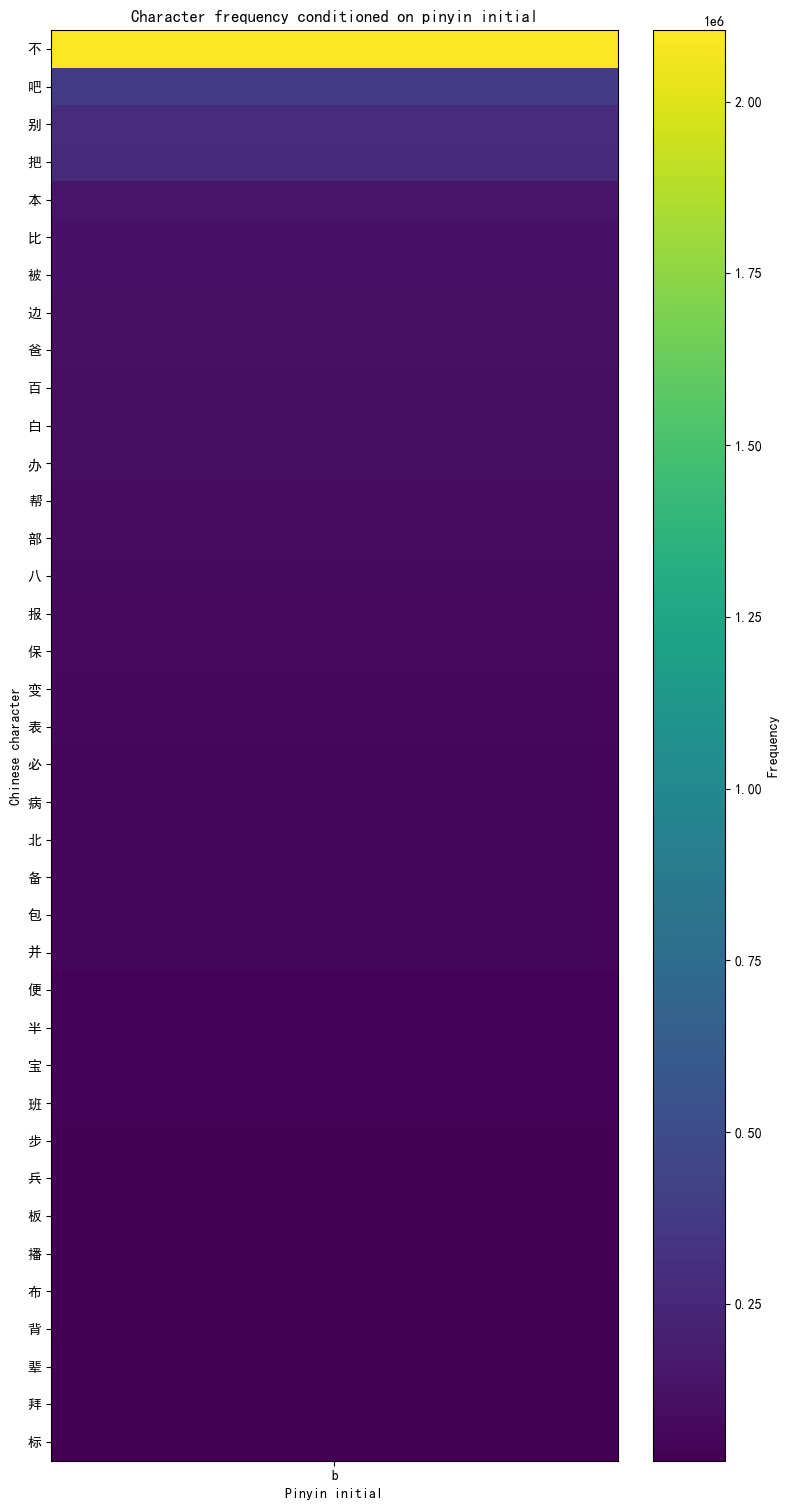

       c
出   357305
成   198140
吃   153503
才   144515
从   144386
次   141696
常   113090
车   87481
场   83921
错   72301
处   70723
此   70156
城   54975
查   53874
产   52163
持   44905
程   40407
传   40192
楚   39294
差   34266
陈   33950
除   30229
曾   29086
参   28603
察   27259
穿   26258
村   25812
承   25457
初   24912
菜   24589
创   22801
超   22397
唱   22143
存   22079
朝   21831
春   21471
冲   20873
藏   19394
财   17725
草   17705
茶   15603
称   15495
厂   15421
吵   15043
臣   14877
床   13486
彩   13356
层   13310
采   13283
船   13090
充   12986
餐   12932
尝   12295
测   12141
猜   11935
材   11852
操   11506
词   11450
策   11441
诚   11382
仇   11147
刺   10611
沉   9879
触   9722
撤   9608
抽   9561
川   9399
晨   9395
聪   8846
辞   8787
迟   8701
吹   7877
彻   7628
纯   7398
曹   7347
厨   7150
残   7018
臭   6695
窗   6654
趁   6207
撑   6140
擦   6004
扯   5952
仓   5595
插   5382
池   5233
惨   5129
拆   5098
础   5053
闯   5013
偿   4825
昌   4724
裁   4675
潮   4657
脆   4496
乘   4433
炒   4333
蔡   4324
丑   4248
辰   4211
措   4192
崇   4147
凑   

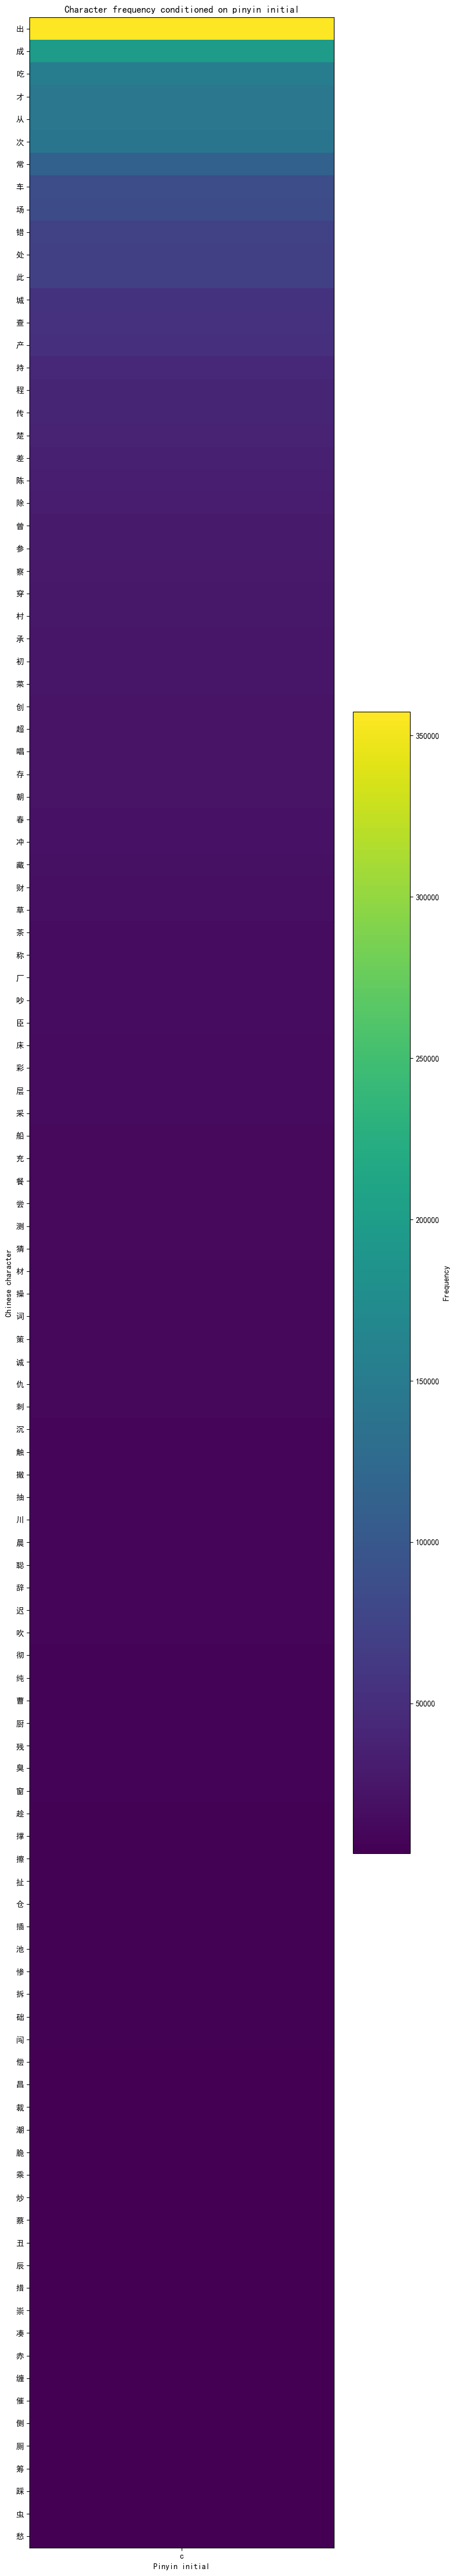

       d
的   3861314
大   612162
到   598131
都   578265
得   528807
对   439412
多   360500
道   347896
点   295897
地   271464
当   242145
定   215614
但   199298
打   185739
动   133281
等   128337
东   116441
带   100006
第   96026
电   92493
队   80138
弟   64896
底   62746
代   60188
度   60124
单   49987
段   43590
调   42193
倒   40055
待   38783
导   38757


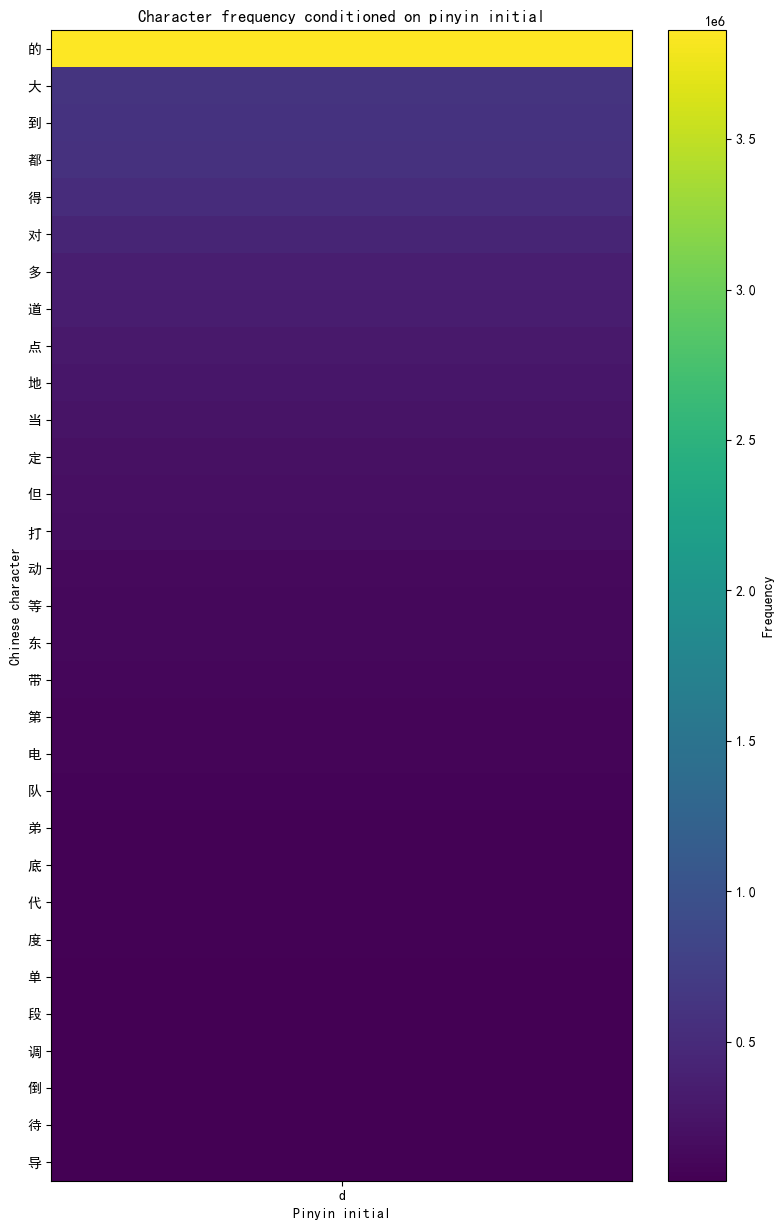

       e
儿   510137
二   190204
而   149227
呃   65219
尔   16116
恩   15081
恶   11960
耳   9582
饿   9049
额   8386


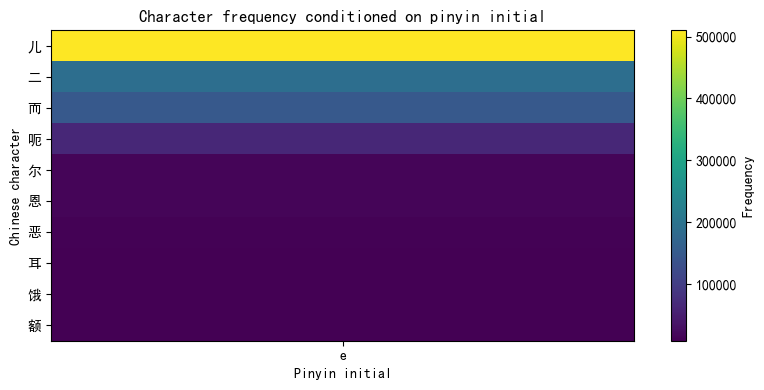

       f
发   200247
方   185266
分   157691
放   132027
法   125870
非   89182
父   65792
房   64637
反   60807
服   58021
夫   56399
饭   55544
风   51431
份   39349
复   36117
飞   34898
福   32741
负   30435
费   30005
烦   23989
妇   22769
犯   22428
府   22042
防   20381
付   18775
否   16756
副   16385
封   16013
富   15521
翻   13811
傅   13476
范   13417
粉   10464
峰   10081
废   9888
凡   9590
疯   8962
凤   8550
访   8260
菲   7831
附   7729
丰   7683
佛   7667
罚   7170
幅   6976
匪   6939
芬   6734
奋   6695
番   6003
妃   5796
伏   5788
奉   5757
肥   5676
啡   5392
冯   5323
纷   5074
肺   4933
符   4812
扶   4769
繁   4446
芳   4140
返   4011
腐   3859
仿   3854
缝   3624
锋   3470
咐   3388
抚   3331
浮   3269
肤   3147
愤   2960
逢   2854
乏   2835
覆   2827
坊   2758
腹   2748
赴   2726
赋   2570
吩   2500
弗   2488
辅   2464
妨   2339
贩   2230
蜂   2059
枫   2037


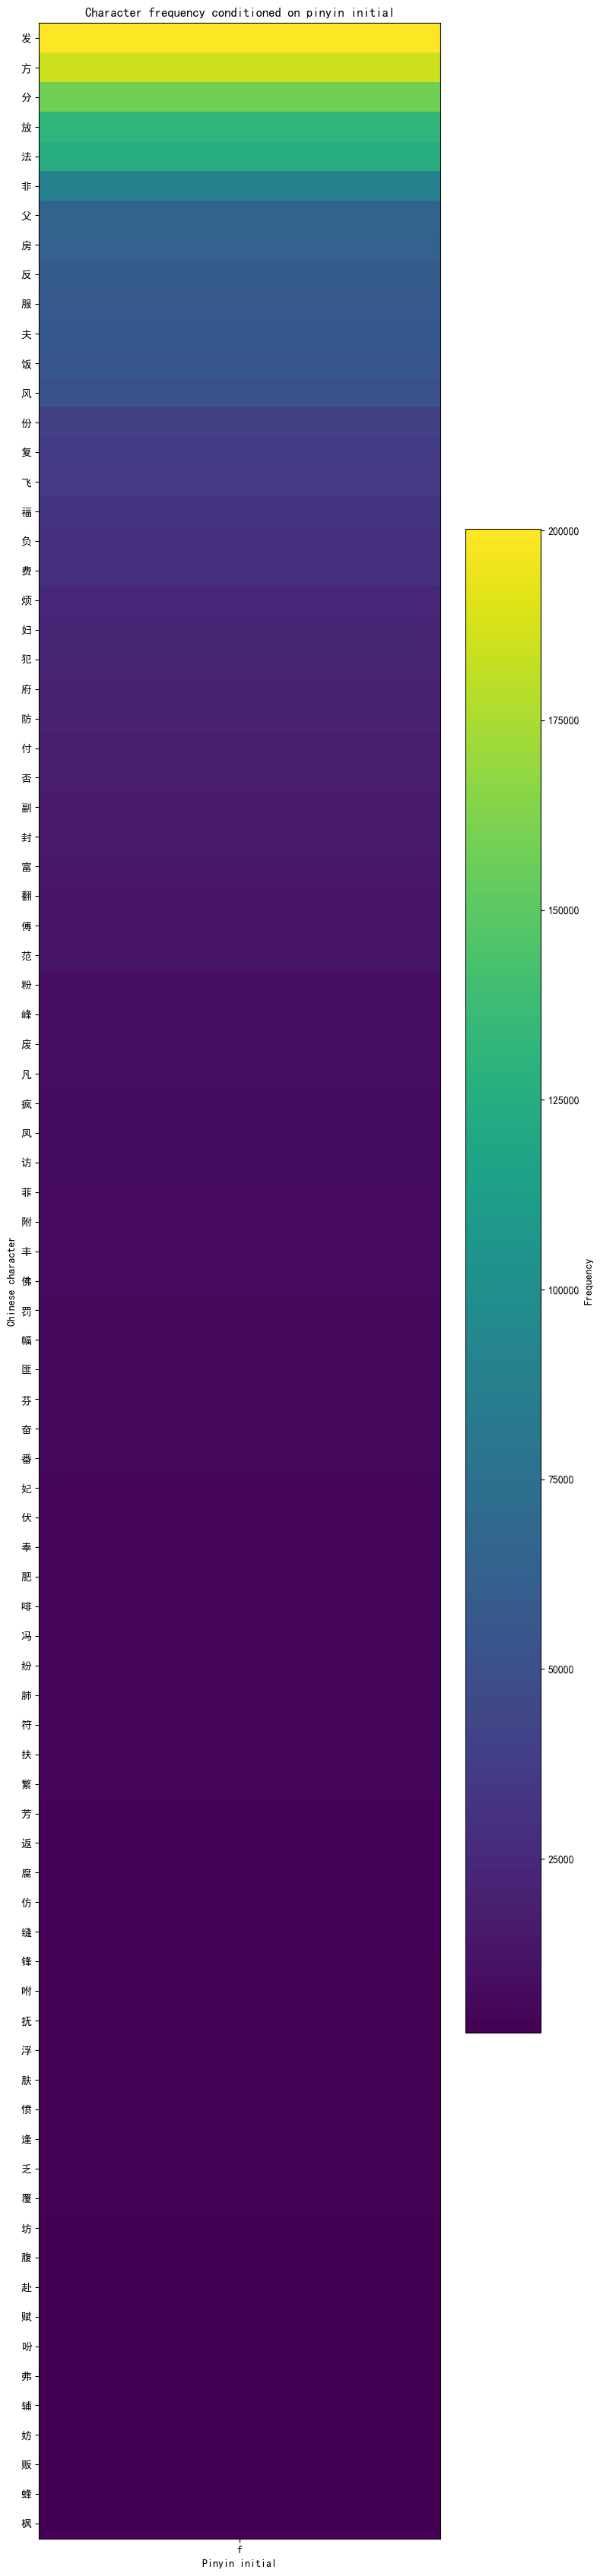

       g
个   1375548
过   418290
给   381257
跟   359393
国   208145
果   160670
公   149886
关   142093
干   138772
感   130191
哥   125912
该   122026
高   115635
工   115321
告   108340
刚   105660
更   88127
管   77107
够   68229
光   52371
赶   49315
各   48804
共   45721
根   44885
敢   42270
官   40828
故   39360
改   38865
功   38395
姑   37702
怪   33703
格   33081
顾   33018
观   32962
歌   29578
鬼   27861
规   27061
广   24656
贵   23412
股   21879
搞   21621
古   21007
宫   20359
狗   19552
馆   15350
概   14365
归   14240


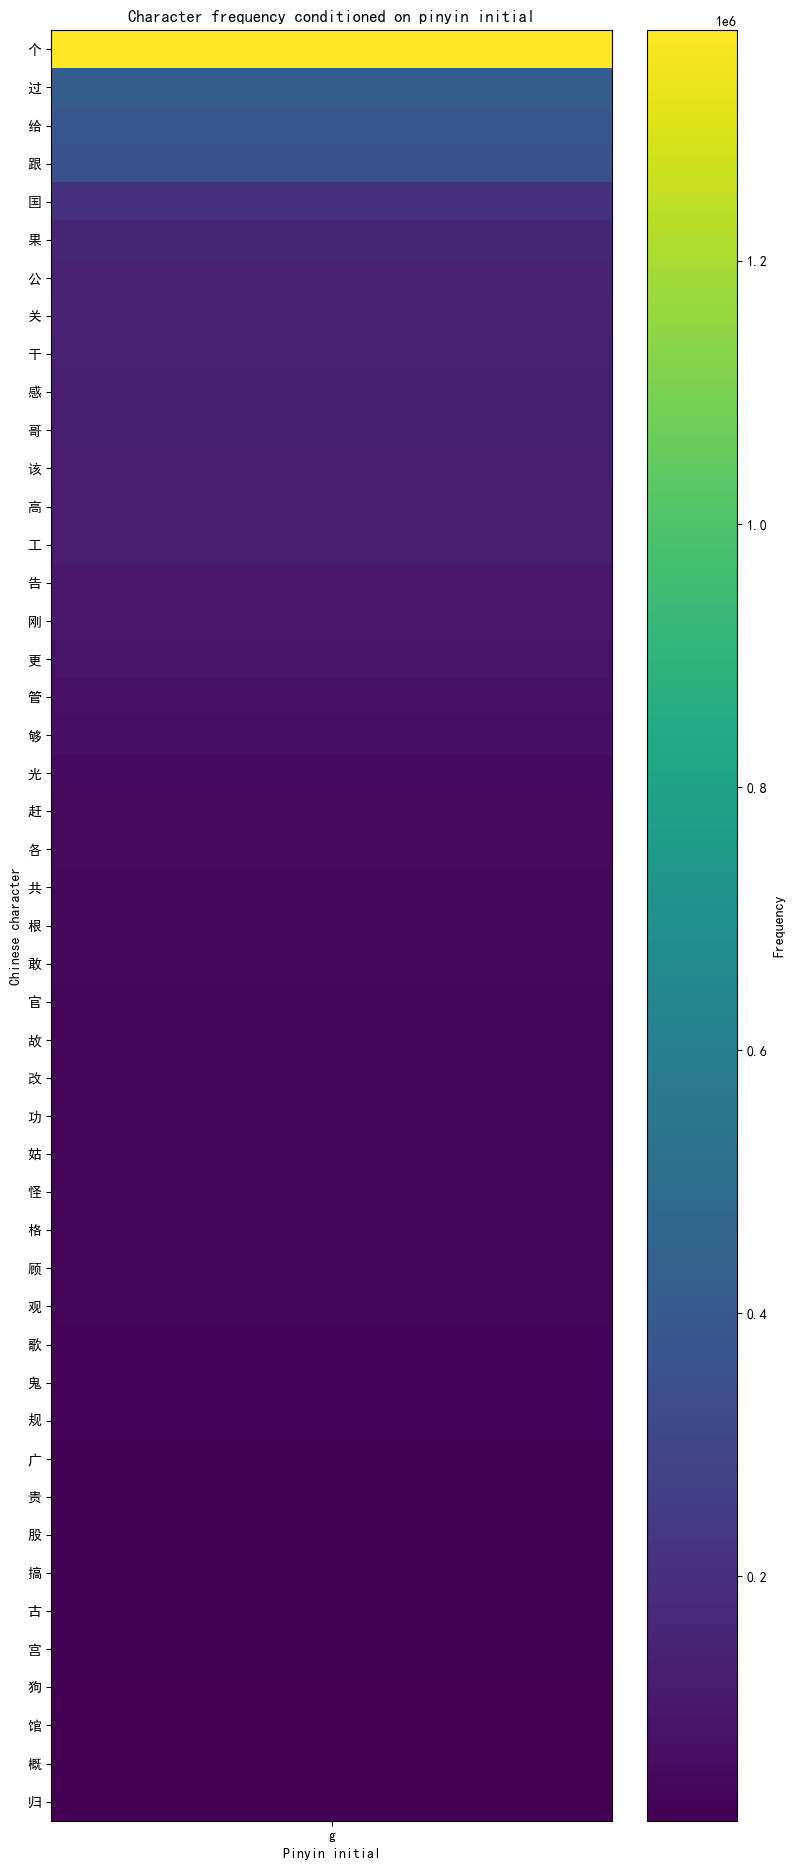

       h
好   794417
还   545436
会   523047
后   421056
回   268119
很   263677
话   263205
和   258348
候   218549
孩   123579
活   105892
欢   93748
合   84561
何   76489
婚   70072
海   68126
花   67073
喝   57687
害   52262
号   50625
化   48697
火   43118
或   41447
红   40154
皇   39942
护   34285
换   30429
华   29887
黄   29887
黑   28028
画   27683
怀   26683
坏   24318
胡   23177
河   22397
哈   22095
汉   22043
伙   21731
划   21668
乎   19282
户   18998
环   18203
货   17285
获   16994
互   15504
虎   13065
呼   12883
湖   12001
混   11836
韩   11788
恨   10963
挥   10738
核   8894
悔   8841
喊   8773
航   8689
糊   8305
魂   8245
慧   8221
患   7950


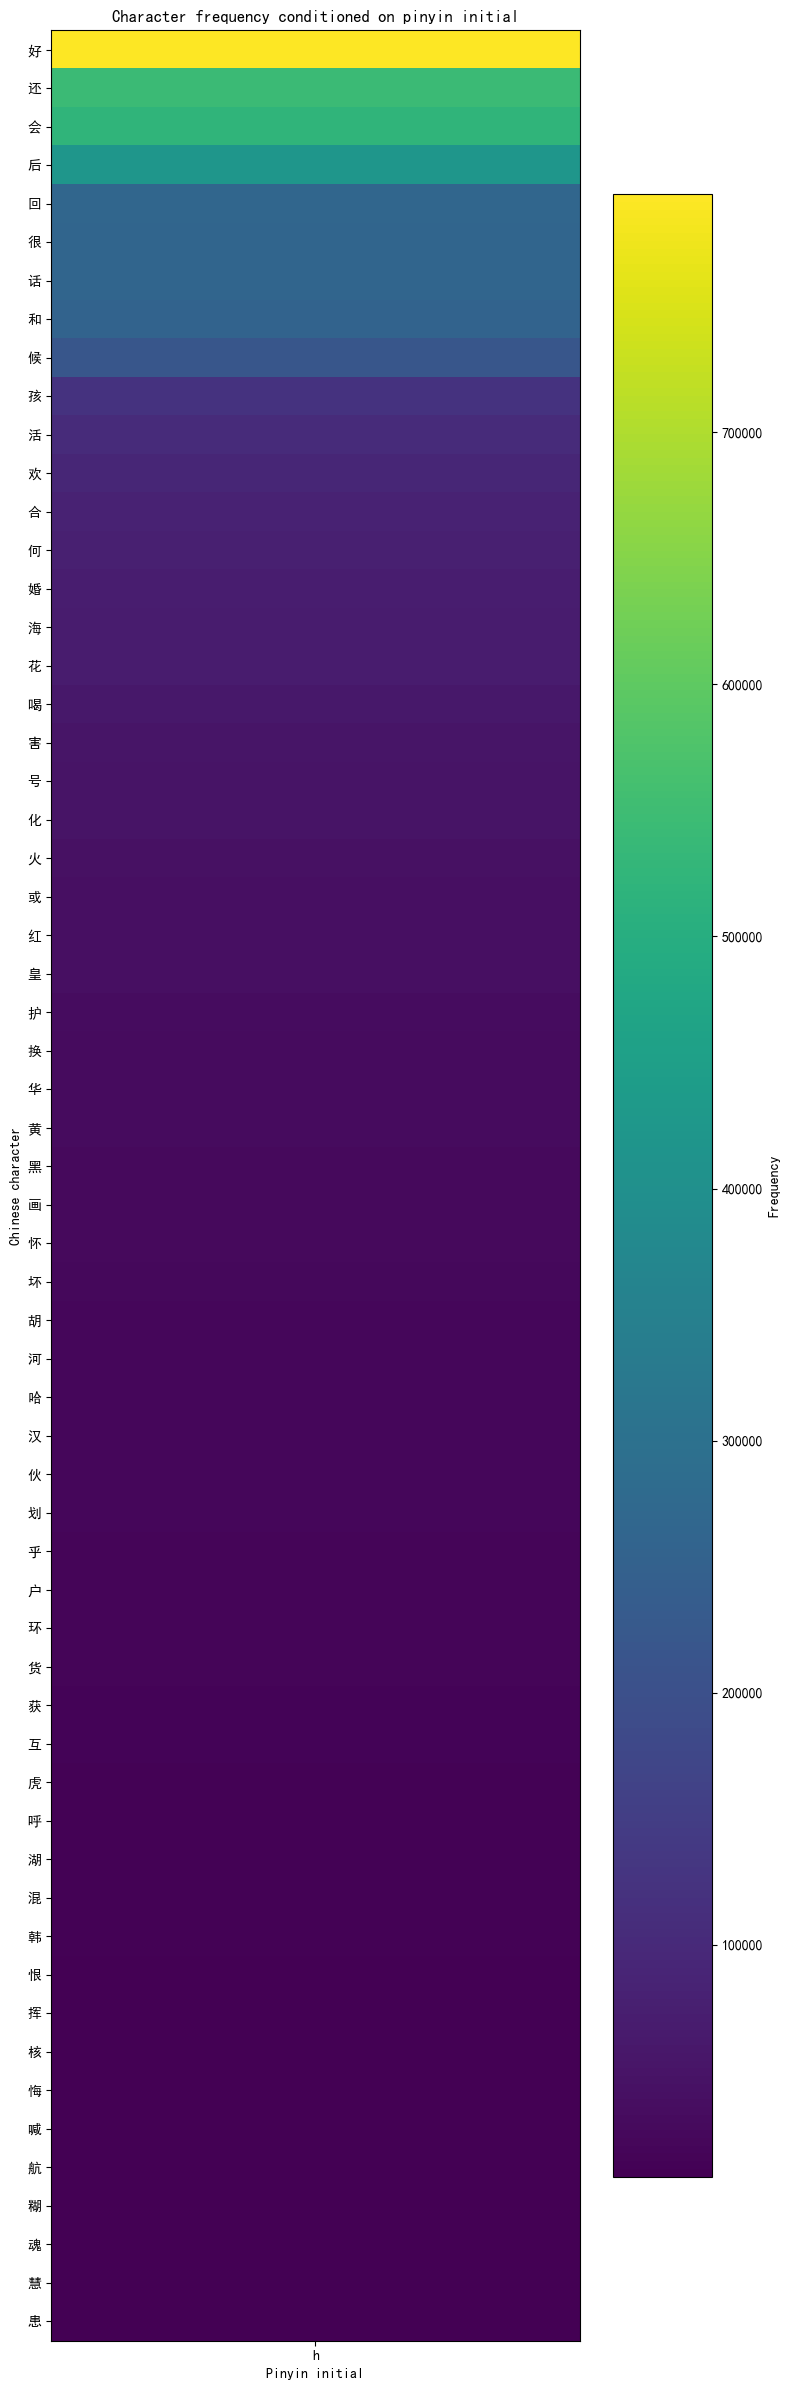

Skipping initial 'i' as no characters are present.
       j
就   1257639
家   444453
经   223763
己   218255
觉   207816
间   161986
今   158809
见   157499
进   132211
军   112275
姐   111822
机   103853
几   102904
接   102401
叫   99661
解   93219
结   88467
记   82213
件   78770
加   78653
将   78293
九   69761
交   66448
讲   62295
金   61046
教   53443
计   53027
紧   52941
决   50508
节   49553
近   48868
句   47459
酒   45286
救   43894
建   43847
界   42431
警   40525
据   40163
急   38594
较   37657
绝   37354
局   36181
尽   32728
精   32677
江   32513
久   32437
及   30820
基   29711
京   29257
假   28857
继   28547
价   28302
击   27617
静   26849
竟   26747
既   26376
简   25868
集   24513
究   24389
居   22369
技   21764
级   21434
坚   21292
角   20952
具   20361
际   20139
极   20107
仅   19655
脚   19526
借   19445
即   19242
介   19008
君   18968
境   18914
举   18545
剧   18519
监   17849
架   16779
纪   16720
激   16144
检   15990
济   15428
景   15135
鸡   15033
惊   14869
健   14407
嘉   13448
嫁   13315
降   13049
杰   12814


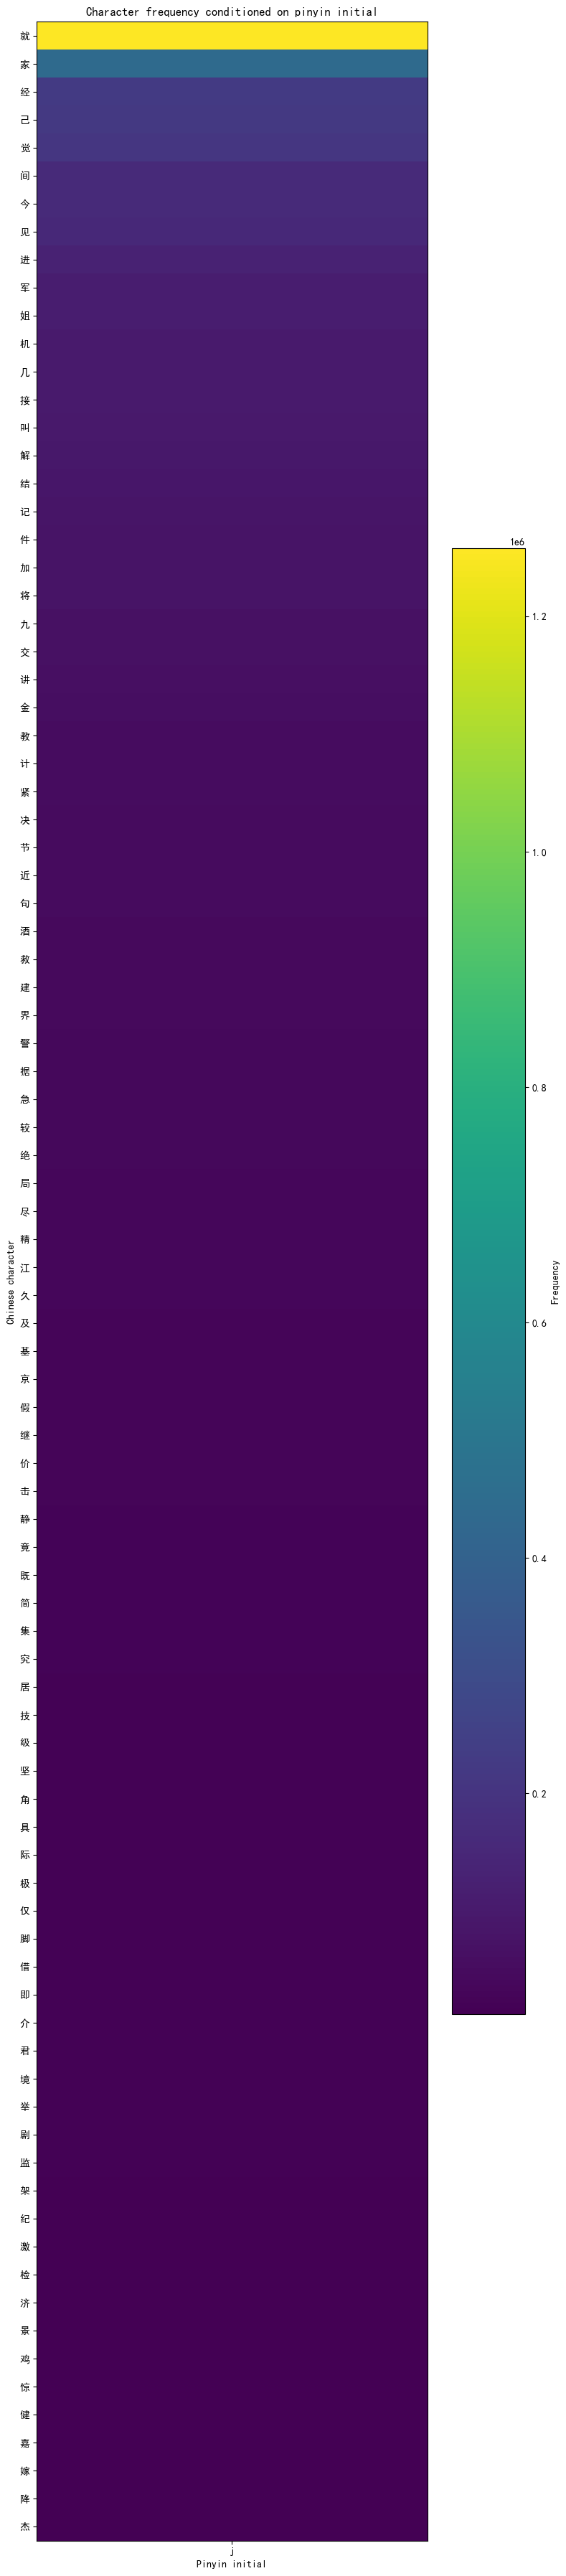

       k
可   496743
看   478978
开   238009
快   145836
口   75915
考   48026
块   46117
况   44882
肯   44673
苦   39351
空   39315
客   36102
科   33155
刻   29845
靠   23328
克   21434
控   20735
哭   20208
抗   17358
康   16738
课   16480
款   15537
困   14714
恐   14291
括   14044
卡   13768
亏   9845
库   7563
颗   7105
宽   6799
狂   6335
夸   5897
咖   5817
扣   5244
凯   5137
孔   4989


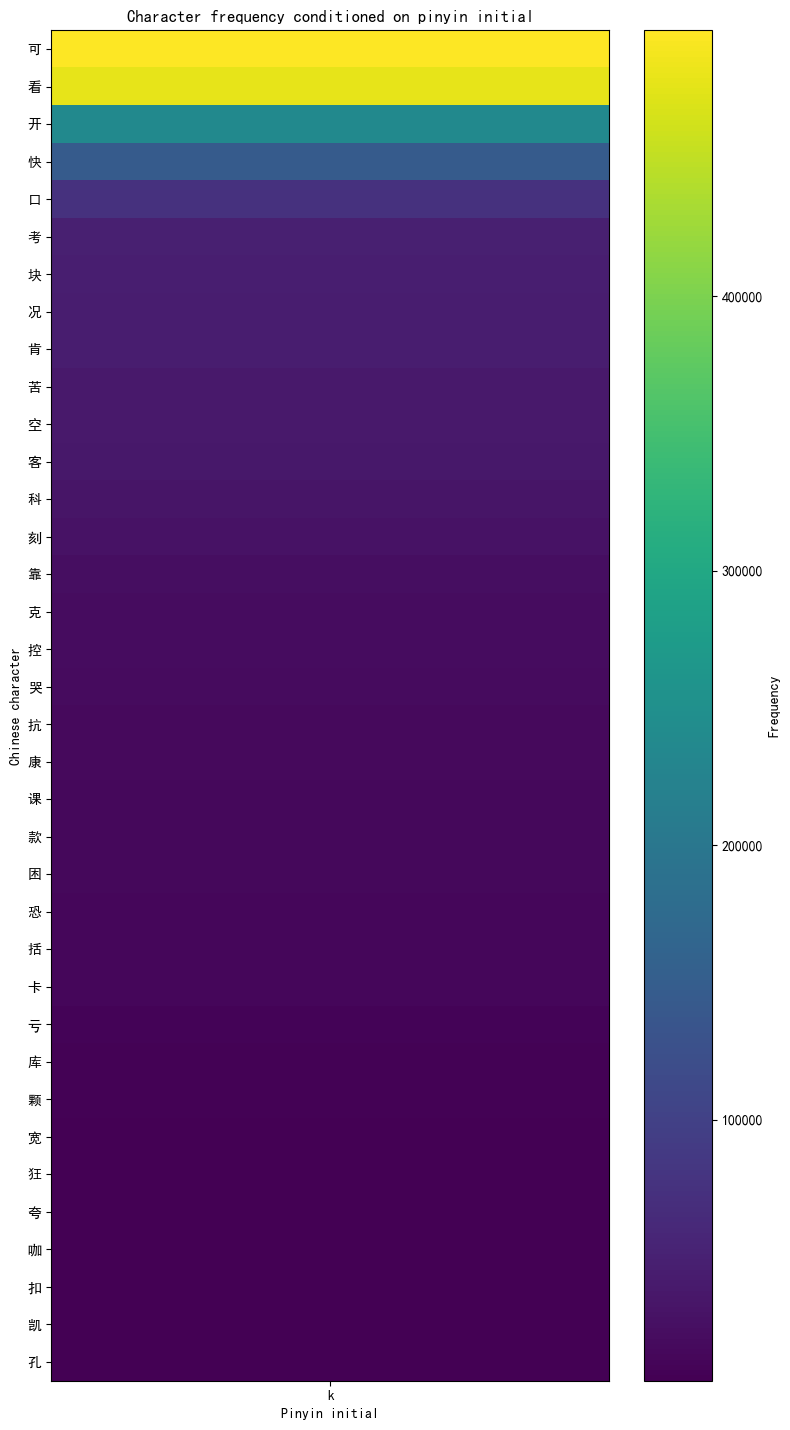

       l
了   2274998
来   965340
里   338426
老   284348
两   171778
理   120288
力   118254
路   78854
离   71628
俩   65281
六   65103
连   55696
留   53587
量   53294
零   51948
李   51538
利   50747
乐   48888
立   46401
林   42631
啦   40934
流   38494
联   36464
拉   35996
聊   35927
刘   35892
领   34048
令   33662
论   32347
亮   30949
龙   30499
脸   29986
落   28571
历   28461
礼   27907
楼   23813
练   23790
乱   23534
另   22862


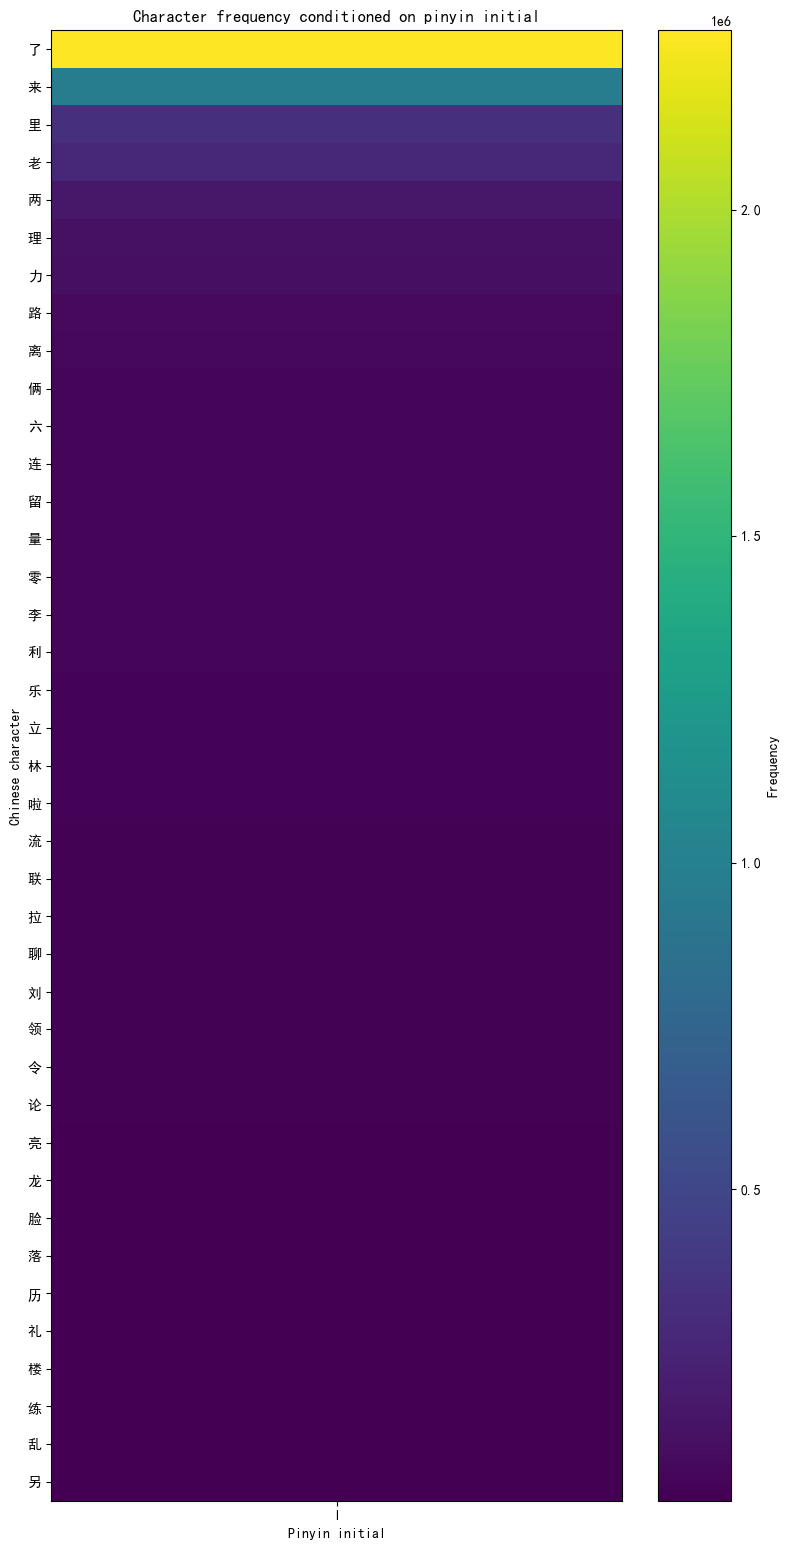

       m
们   1148088
么   1102428
没   615256
吗   404257
面   220697
明   173062
妈   155440
马   85711
美   84599
门   78253
名   78195
嘛   77425
每   77002
命   73049
目   71834
民   59683
买   58032
母   45759
妹   42487
慢   41499
满   37045
忙   36293
卖   34214
密   28762
梦   26811
毛   24540
麻   22884
米   20646
模   17513
某   17342
秘   16759
木   14844
码   14427
免   12521
迷   12112
麦   11513


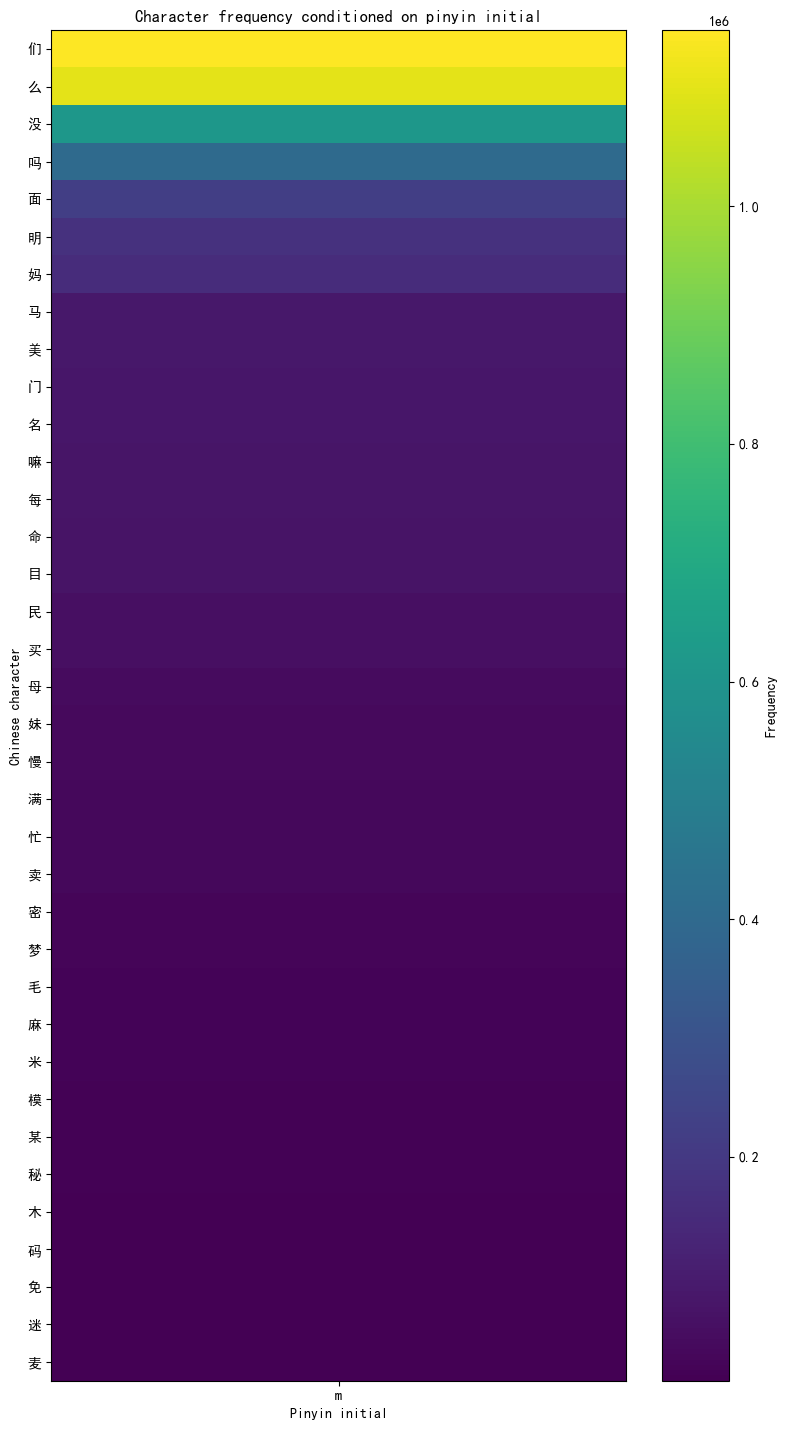

       n
你   2796972
那   862787
能   526909
呢   449291
年   259312
您   207654
女   160074
哪   140376
难   93374
嗯   80615
拿   79059
男   78718
娘   71506
内   58141
南   48377
奶   35832


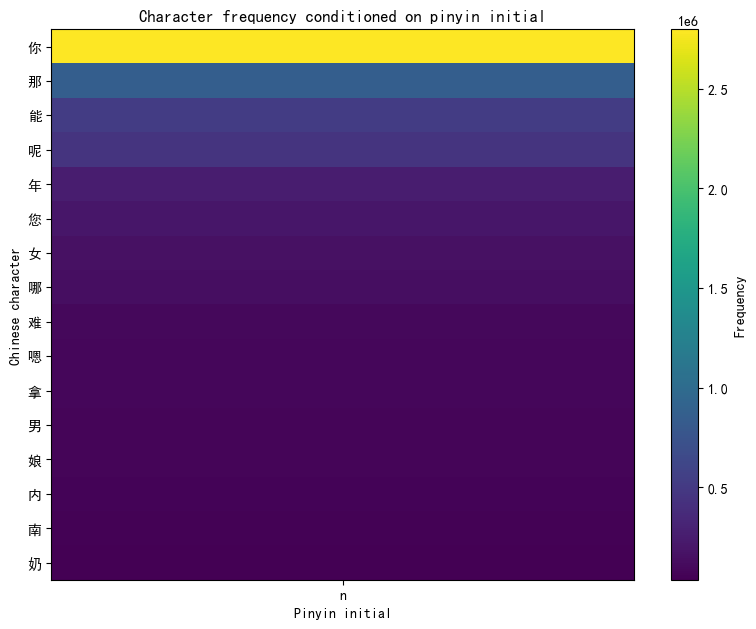

       o
哦   29761
欧   10803
偶   6257
鸥    823
殴    553
藕    369
呕    356


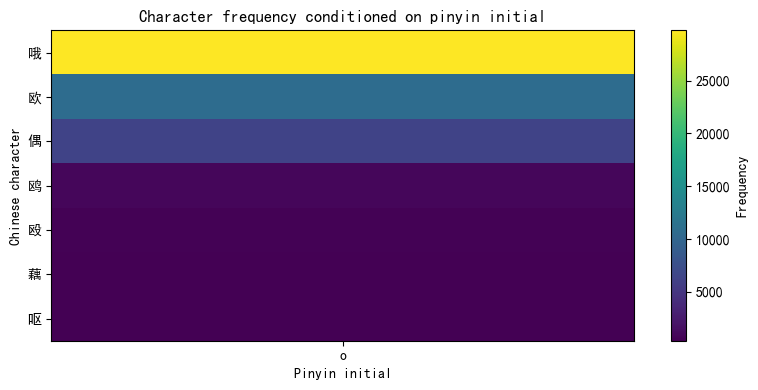

       p
朋   82668
平   76178
怕   68929
跑   43866
品   41316
片   37875
陪   31576
排   30738
破   27904
派   26094
拍   25772
婆   25621
配   22307
骗   20766
皮   17550
票   17390
批   15112
漂   15014
牌   14552
评   14339
判   13664
碰   13548
凭   13450
普   13207
频   12110
盘   11864
拼   10276
旁   10272
偏   10217
胖   9180
脾   8237
屁   8192
赔   7651
炮   7530
泡   7328
瓶   7066
培   6536
迫   6311
叛   5952
佩   5822
铺   5658
爬   5468
篇   4796
屏   4755
谱   4624
贫   4507
彭   4417
鹏   4316
抛   4149
苹   3478
潘   3449
坡   3379
盼   3338
飘   3148
喷   3142
盆   3005
匹   2813
扑   2633
聘   2409
萍   2395
疲   2232
庞   2217
泼   2064
捧   2034
披   1928
啪   1884
趴   1830
朴   1734
攀   1614
魄   1413
劈   1413
葡   1395
棚   1371
浦   1370
沛   1367
颇   1303
泊   1258
袍   1248
辟   1173
撇   1104
啤   1040
菩   1003
裴    979
呸    944
帕    894


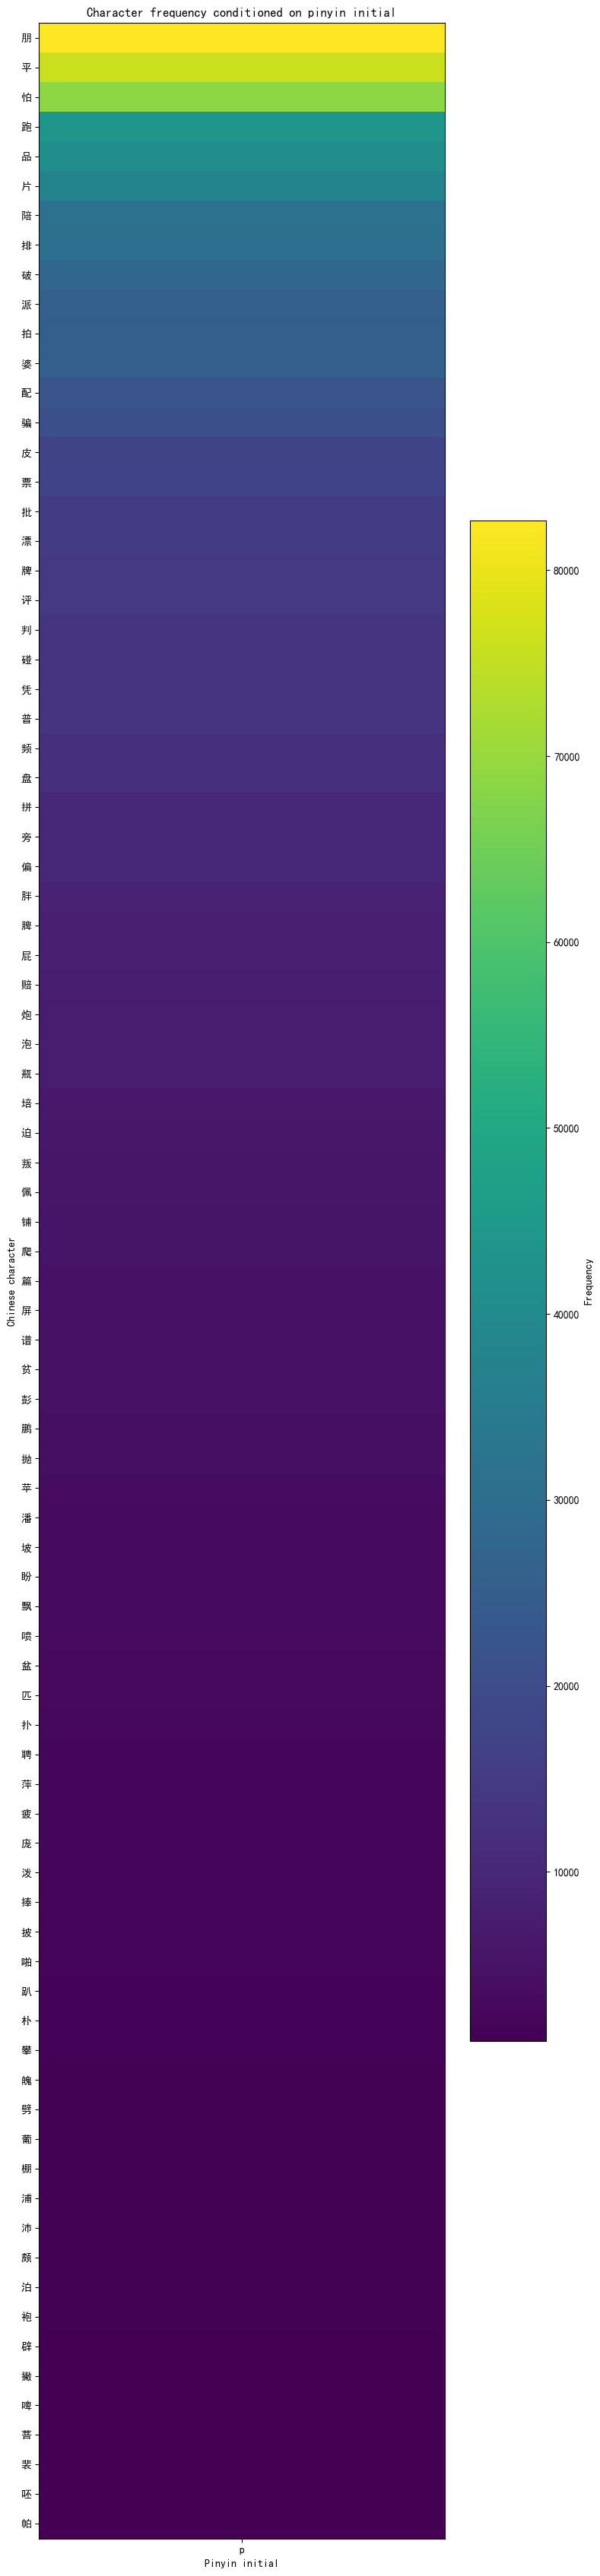

       q
去   579163
情   244399
起   232968
前   190213
其   143013
钱   127571
全   125519
气   100250
请   95531
亲   93044
清   73886
七   59069
千   57665
求   57056
期   55780
且   53465
确   53065
强   49878
区   39925
轻   38512
却   35776
切   32996
取   31715
青   30498
奇   27279
枪   25075
权   22361
球   22345
器   21588
妻   18550
弃   17289
群   16079
抢   14393
缺   13836
圈   13220
庆   13189
企   13126
秋   12947
秦   12857
齐   11979
签   11243
劝   10934
曲   10645
趣   10526
欺   10297
巧   10276
瞧   9978
歉   9460
桥   9294
欠   8893
屈   8100
启   8016
娶   7865
墙   7487
乔   7232
琴   7227
穷   7170
牵   6758
潜   6546
骑   6404
戚   6274
汽   6089


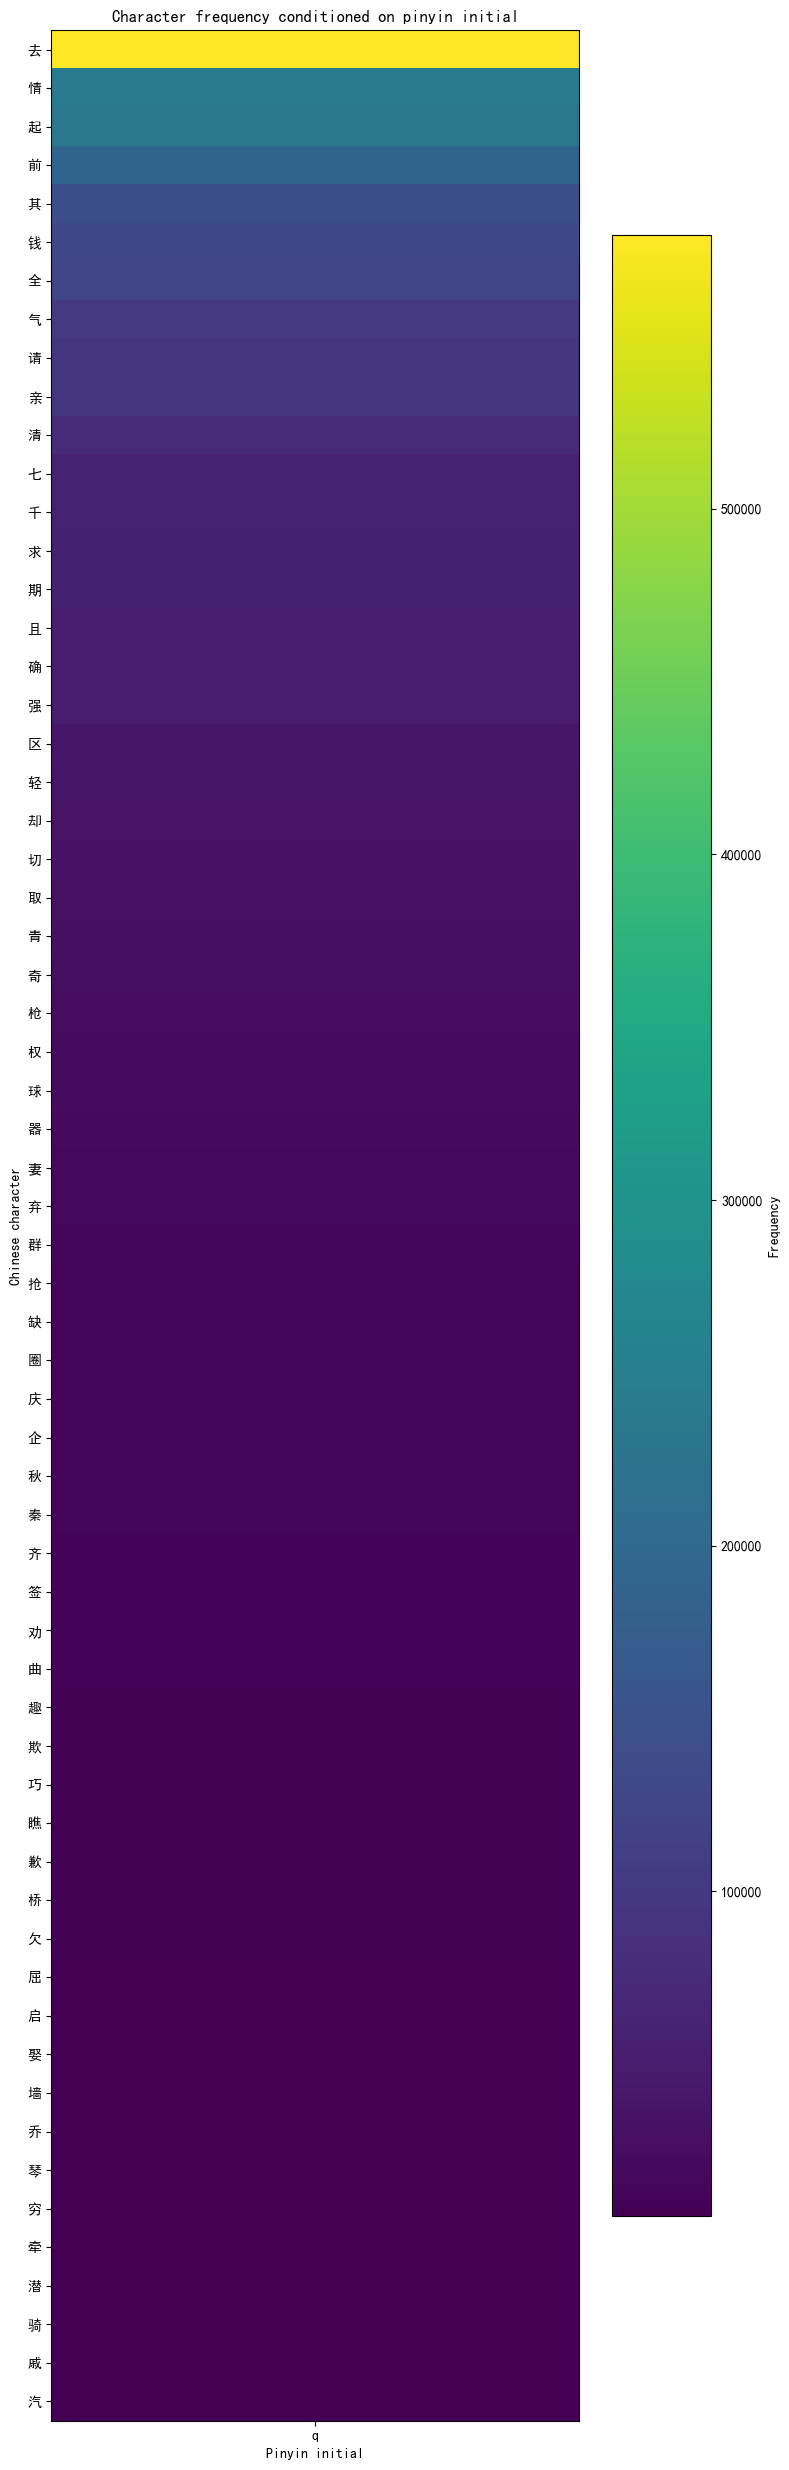

       r
人   1002026
然   302131
让   247200
如   206803
日   118974
任   85586
认   84209
入   59629
容   42681
热   29960
肉   19599
若   16695
忍   14404
荣   11205


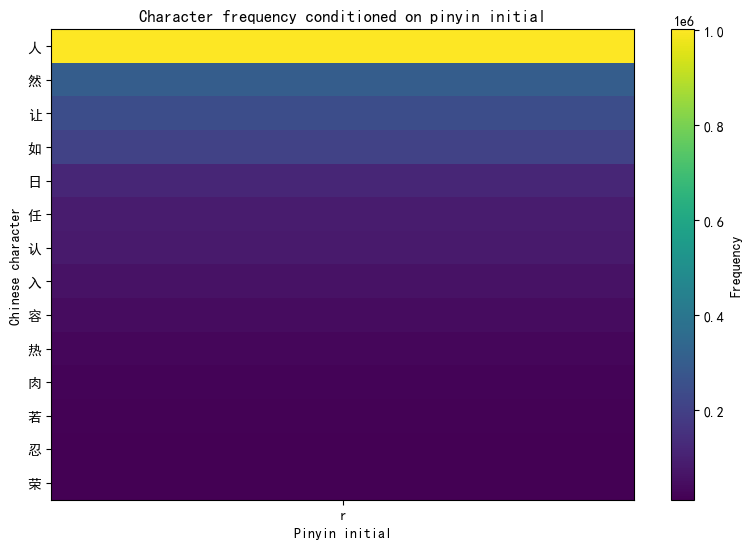

       s
是   2693058
说   903922
上   561817
什   519166
时   476366
事   455786
生   323540
十   238586
所   225634
实   207053
三   191992
手   161905
身   125731
师   123336
死   115295
谁   113576
少   101895
四   96860
思   86333
算   85317
受   81874
诉   79321
水   77347
山   76160
司   64542
始   63506
送   62241
世   61011
收   57461
杀   53993
市   53167
书   50498
啥   49332
伤   48577
声   48044
神   47957
失   47790
数   46760
识   44943
睡   40910
岁   38583
首   37873
叔   37087
商   36930
试   36925
深   36409
式   36070
随   35674
色   34891
术   33522
视   32124
使   31520
设   31100
士   29962
虽   28695
石   27518


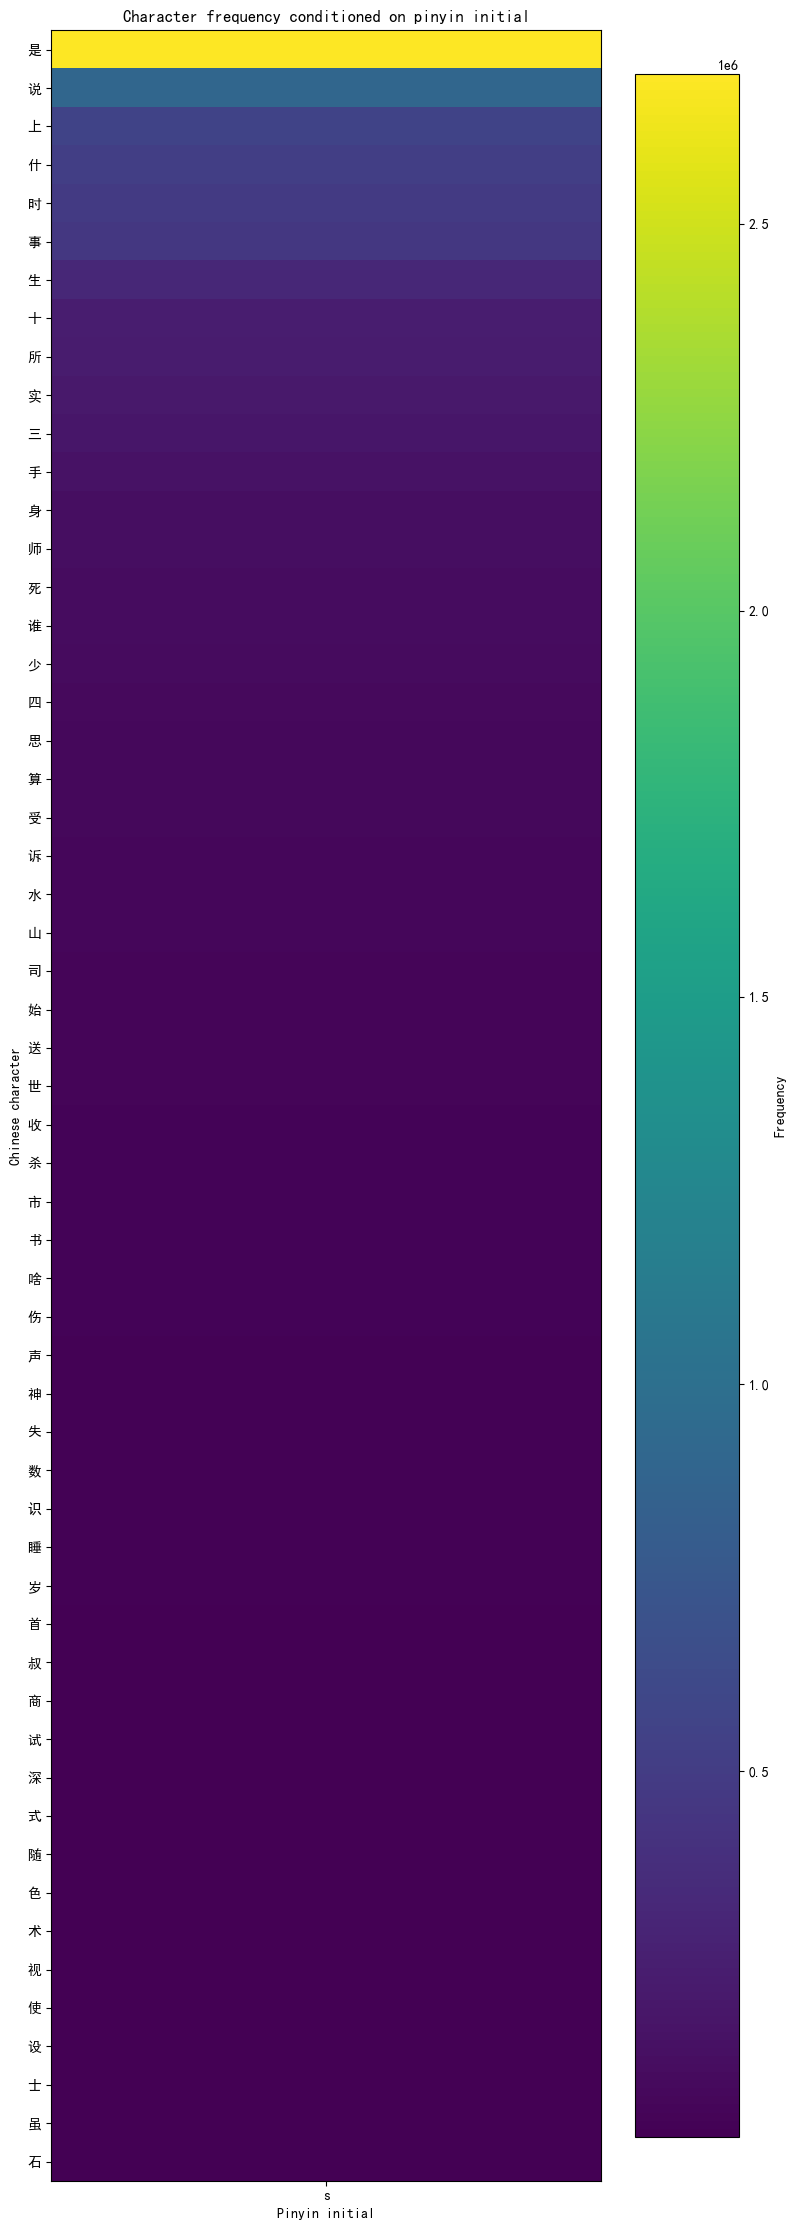

       t
他   1015863
天   436916
她   281211
太   164769
听   159473
同   141073
头   123720
特   107328
它   106482
题   92245
通   77042
体   76904
提   65755
挺   54447
条   53199
团   43857
台   43646
谈   35555
突   31317
态   29172
投   27787
统   26406
推   23704
停   22255
图   20920
堂   20288
偷   20287
替   20283
土   19971
退   19249
铁   19213
跳   18944
痛   18721
庭   18123
套   17852
唐   17392
挑   16629
疼   16509
田   16281
逃   16160
讨   15168
探   13624
脱   12826
托   12605
腿   11063
厅   10652


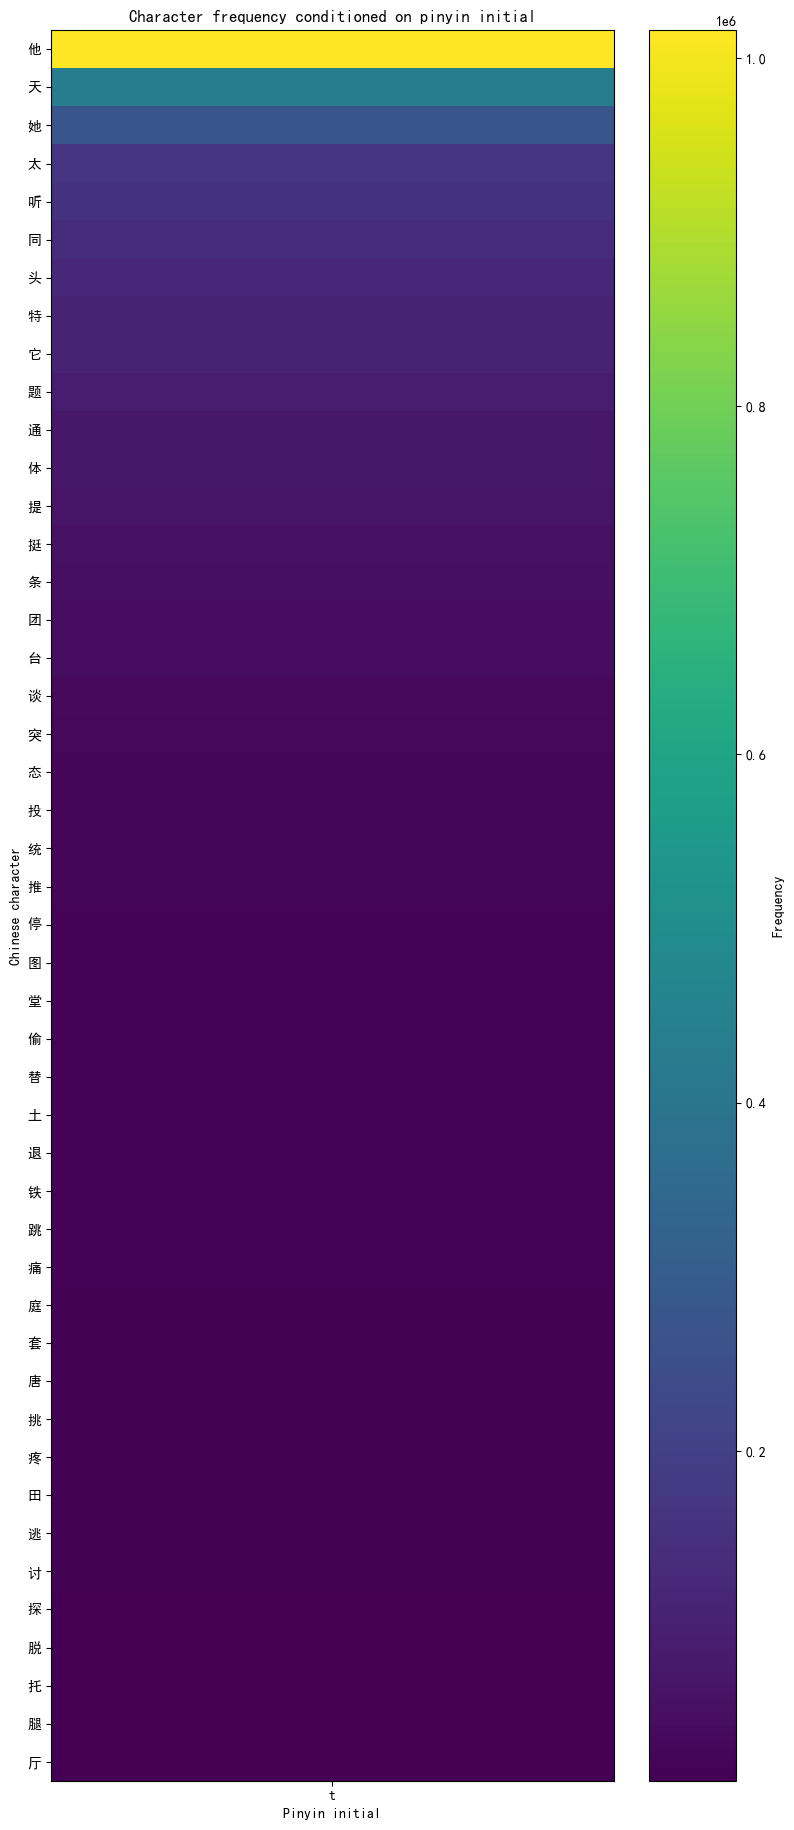

Skipping initial 'u' as no characters are present.
Skipping initial 'v' as no characters are present.
       w
我   3512771
为   494491
问   177025
无   111575
位   106285
五   104817
外   100744
完   100731
王   89987
万   87631
晚   71924
望   68293
文   67894
物   59582
往   53422
务   48697
玩   48144
未   35361


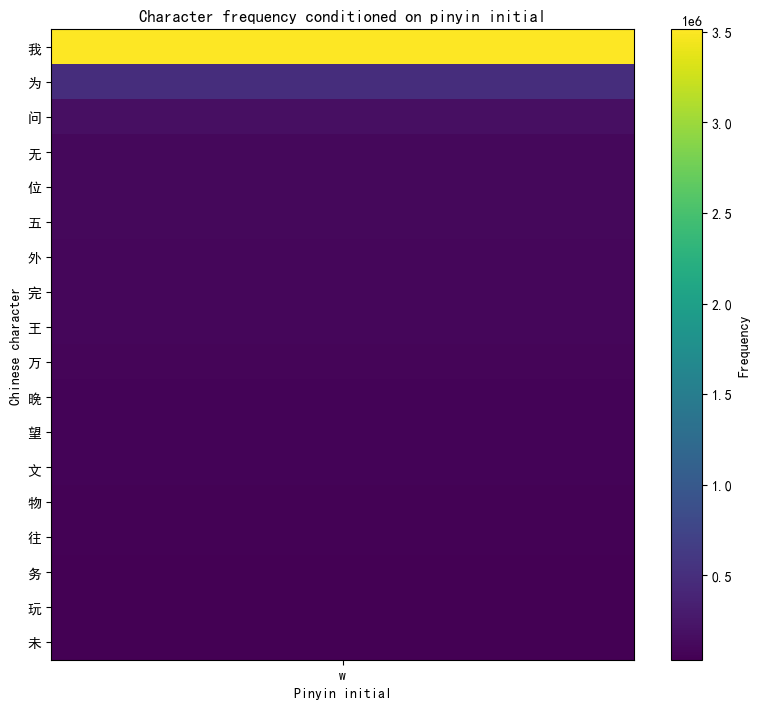

       x
想   441230
下   424137
小   372228
现   341865
心   330456
行   243612
些   193052
谢   159500
学   154632
先   147594
信   111758
西   111313
相   110250
像   108244
喜   97059
新   93974
系   77786
向   63413
性   59238
需   52717
息   51320
希   46845
选   46152
许   44636
兄   44562
消   41467
笑   39672
线   38144
写   37504
续   34579
兴   34432
象   30577
习   30450
戏   29243
须   28535
幸   27693
星   27549
醒   26328
香   26314
险   26236
校   25102
形   24811
血   24691
响   21941
休   21865
细   21760
修   20335
姓   19484
雪   19242
洗   19138
项   19033
显   18841
夏   18298
享   17710
晓   16946
秀   16565
媳   16161
辛   16152
乡   15750
型   15065
嫌   14869
训   14385
效   14275
县   13783
徐   13122
吓   12291
寻   12145
宣   11912
绪   11688
凶   11437
限   11235
惜   11039
销   10848
吸   10455
协   10413
雄   10348
虚   10278
席   10255
鲜   9847
仙   9668
瞎   9006
鞋   8865
箱   8528
熊   8072
陷   7877
讯   7785
刑   7672
闲   7581
析   7139
孝   6899
献   6378
欣   6043
序   5882
悉   5882
牺   5609
贤   5587
肖   5467
袭   4930
歇   4760
胸   4720

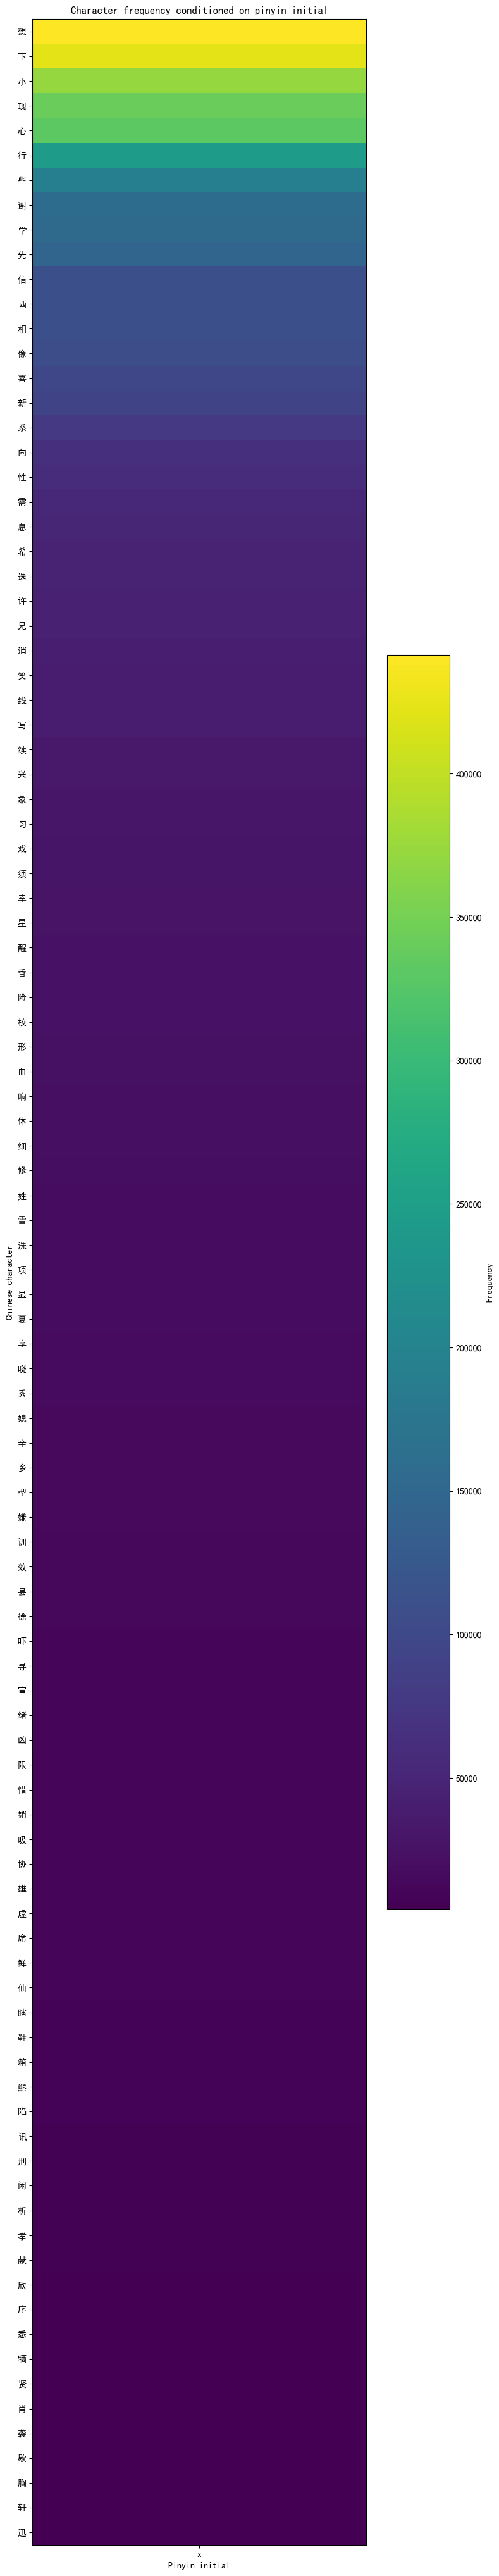

       y
一   1911140
有   1249715
要   755661
也   550087
以   468359
样   314277
呀   269905
意   221600
用   174032
因   167024
已   148116
于   134729
又   131982
应   125477
友   101887
月   89844
业   80591
爷   72695
原   67917
眼   67078
员   62077
医   59234
院   58740
越   57731
远   50907
与   50824
演   48968
愿   47585
影   46252
由   41796
易   39489
义   37294
言   37054
音   35270
药   35097
运   33462
养   33120
元   31724
衣   31345
夜   29698
疑   29584
阳   28938
遇   28641
游   28392
英   26623
云   25797
严   25096
约   24752
油   24528
迎   23988
议   23432
营   23407
杨   23391
验   22950
永   22681
玉   22046
姨   22024
压   21244
研   20227
雨   20063
依   19662
语   19139


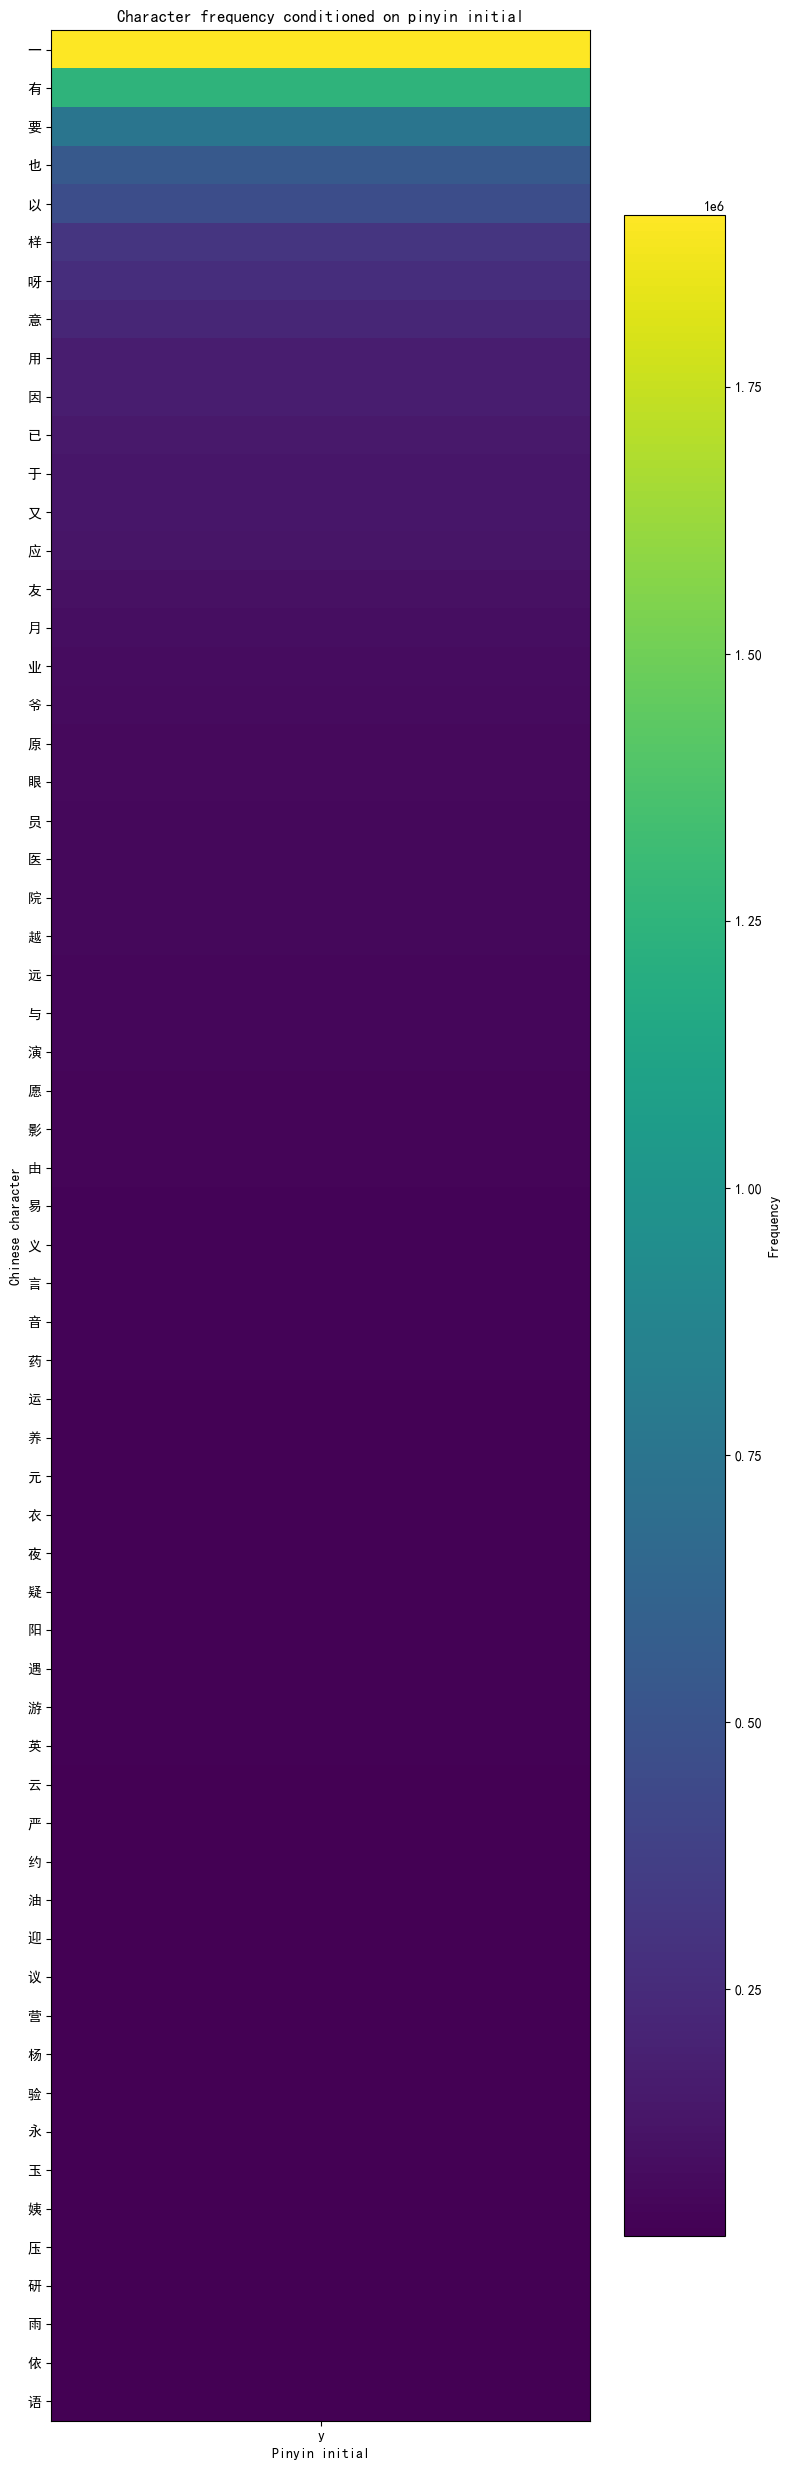

       z
这   1830497
在   1046110
子   541101
着   337368
自   328776
怎   320675
知   299232
中   268201
真   258712
之   233623
做   226693
长   221194
走   215274
再   192754
最   189675
只   183062
找   156194
种   148816
作   146271
咱   145562
主   127331
正   126363
重   118536
直   106179
住   90044
总   88031
张   81395
者   80120
早   73099
战   70833
准   56274
照   55265
证   51825
坐   50007
字   47028
资   47007
整   46995
周   44566
至   44496
制   42080
志   41263
指   39982
站   37682
政   35622
转   35287
终   34532
注   33958
装   33900
组   32611
抓   32524
展   31656
造   31384
专   30444
责   29044
支   29035
治   28824
众   27693
助   26126
值   25780
争   25650
追   25628
罪   25222
择   24110
钟   23566
足   23228
质   23070
州   22079
嘴   21386
咋   21190
职   21106
则   21103
状   20825
昨   20440
招   20303
置   19633
座   19510
赵   19464
掌   18884


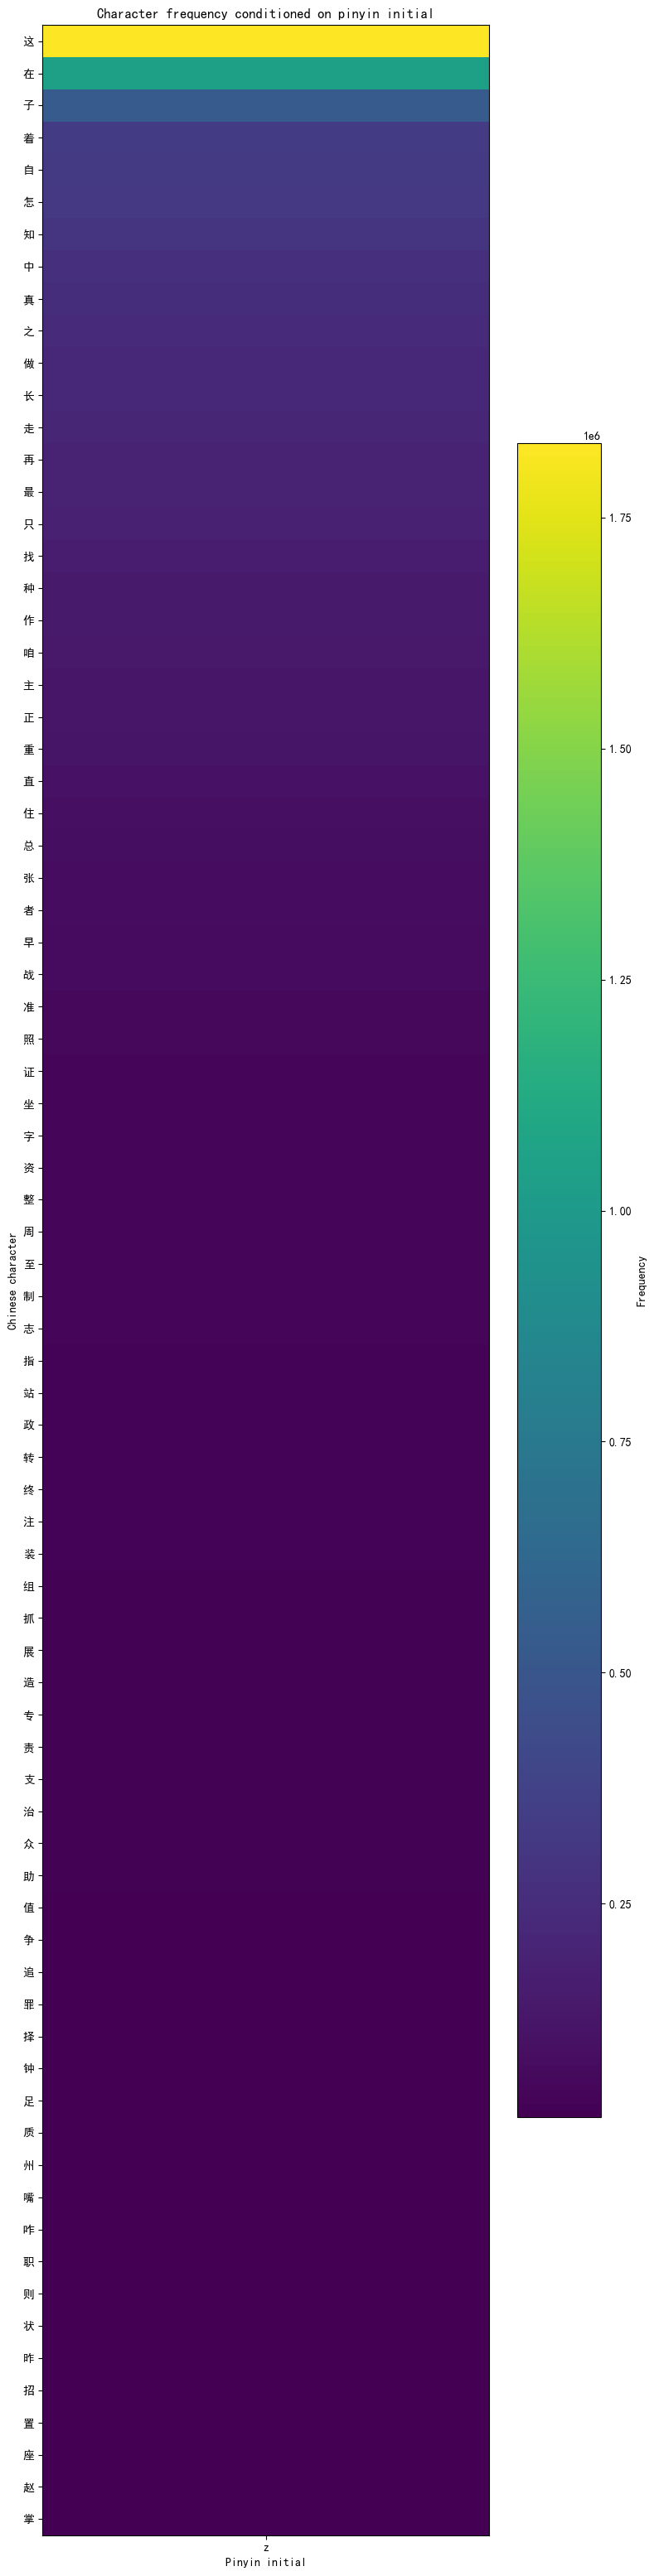

In [ ]:
# ---------- 5. Example usage ----------

if __name__ == "__main__":
    # Example training data.
    # Replace this with your own corpus (webtoons, BabyLM, etc.).
    training_texts = zho_text_cleaned

    # 1) Build counts
    initial_to_counts = build_initial_to_char_counts(training_texts)

    # Ensure the output directory exists
    output_dir = "zho_frequency"
    os.makedirs(output_dir, exist_ok=True)

    # 2) Define initials and characters of interest
    # Include all letters of the alphabet as initials
    initials_of_interest = list(string.ascii_lowercase)

    for initial in initials_of_interest:
        # Check if the initial exists in the data
        if initial not in initial_to_counts or not initial_to_counts[initial]:
            print(f"Skipping initial '{initial}' as no characters are present.")
            continue
        

         # Dynamically determine characters within 1% frequency of the most frequent term
        most_frequent_count = initial_to_counts[initial].most_common(1)[0][1]
        cutoff = most_frequent_count * 0.01  # 1% of the most frequent count
        extra_chars = [ch for ch, count in initial_to_counts[initial].items() if count >= cutoff]

        # Dynamically determine the most frequent characters for the current initial
        # extra_chars = list(initial_to_counts[initial].keys())

        # extra_chars = []
        # if initial in initial_to_counts:
        #     # Get the most frequent character for the current initial
        #     most_frequent_char, _ = initial_to_counts[initial].most_common(1)[0]
        #     extra_chars.append(most_frequent_char)

        # 3) Build matrix (top 5 chars for the current initial + extra_chars)
        initials, chars, mat = build_matrix(
            initial_to_counts,
            initials=[initial],  # Only include the current initial
            extra_chars=extra_chars,
            top_k_per_initial=0,
        )

        # 4) Print table in the desired format
        print_matrix(initials, chars, mat)

        # 5) Save heatmap for the current initial
        heatmap_path = os.path.join(output_dir, f"{initial}.png")
        show_heatmap(initials, chars, mat)
        plt.savefig(heatmap_path)
        plt.show()
        plt.close()

        # 75 minutes 